In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_dir = '/content/drive/MyDrive/Project'

Just run "dataset," "model," and "train"

# **combine_binary_files**

In [ ]:
activity=str(4)
input1 = open('{}/adc_data_m_pu_0.bin'.format(activity), 'rb').read()
input2 = open('{}/adc_data_m_pu_1.bin'.format(activity), 'rb').read()
input3 = open('{}/adc_data_m_pu_2.bin'.format(activity), 'rb').read()

combine= input1+input2 +input3

with open('{}/adc_data_m_pu_Raw_combine.bin'.format(activity), 'wb') as fp:
    fp.write(combine)

# **0_get_names_label.py**

In [ ]:
import os
import glob
#
#Arnab 0
#Hanyu 1
#Max 2
#Nolan 3
#Rachana 4



paths=glob.glob("./*/*_combine.bin")
file = open("names.txt", "w")
for path in paths:
    file_name=path.split("/")[-1]
    activity_name=path.split("/")[-2]
    start_frame=str(100)
    print(file_name, activity_name, start_frame, path)
    file.write(file_name+","+activity_name+","+start_frame+","+path+"\n")
file.close()

# **tool.bin2split_np**

In [ ]:
import numpy as np
import pickle as pk
import multiprocessing
import time
import os

class radarConfig():
    def __init__(self):
        self.NUM_TX = 3
        self.NUM_TX_LOWER = 2
        self.NUM_RX = 4
        self.NUM_TRX = self.NUM_TX*self.NUM_RX
        self.CHIRP_LOOPS = 128
        self.ADC_SAMPLES = 256
        self.NUM_RANGE_BINS = self.ADC_SAMPLES
        self.NUM_DOPPLER_BINS=self.CHIRP_LOOPS

        self.FRAME_SIZE= self.NUM_TX * self.NUM_RX * self.CHIRP_LOOPS * self.ADC_SAMPLES

        self.FRAME_BYTE_SIZE= self.FRAME_SIZE*4
        self.FRAME_INT16_SIZE= self.FRAME_SIZE*2
        self.FRAME_COMPLEX_SIZE= self.FRAME_SIZE

        self.ANGLE_BIN_SIZE=128
        self.FPS=10

class transform():
    def __init__(self):
        self.bin_location='../AWR1843/'
        self.out_root_loc='./'
        self.filename_loc='../AWR1843/'
        self.load_filenames_by_file(self.filename_loc+'names.txt')
        self.skip_sec_from_begin=0
        self.cfg=radarConfig()

    def load_filenames_by_file(self, filename):
        self.filename_list=[]
        self.path_list=[]
        self.sync_dict={}
        with open(filename, 'r') as infile:
            i=0
            for line in infile:
                if line.strip()=='':
                    continue
                file_name=line.split(",")[0]
                start_frame=line.split(",")[2]
                path=line.split(",")[-1]
                self.filename_list.append(file_name)
                self.path_list.append(path.strip('\n'))
                self.sync_dict[str(i)]=int(start_frame)
                i+=1

    def save_np_mat(self, mat, name):
        np.save(name, mat)

    def load_binary_frames(self, infilename, batch_length, skip_size):
        frame_byte_size=self.cfg.FRAME_BYTE_SIZE
        frame_int16_size=self.cfg.FRAME_INT16_SIZE
        frame_complex_size=self.cfg.FRAME_COMPLEX_SIZE
        with open(infilename,'rb') as infile_bin:
            infile_bin.seek(skip_size*frame_byte_size,0)
            frame_read=np.frombuffer(infile_bin.read(batch_length*frame_byte_size), dtype=np.int16)
        assert len(frame_read)==frame_int16_size*batch_length
        frame_out=np.zeros(shape=(batch_length*frame_complex_size,), dtype=np.complex_)
        frame_out[0::2] = frame_read[0::4]+1j*frame_read[2::4]
        frame_out[1::2] = frame_read[1::4]+1j*frame_read[3::4]
        frame_np=frame_out.reshape(batch_length, self.cfg.CHIRP_LOOPS, self.cfg.NUM_TX, self.cfg.NUM_RX, self.cfg.ADC_SAMPLES).transpose(0,2,3,1,4) #(batch_length, 3, 4, 128, 256)
        return frame_np


    def get_processed_frames(self, infilename, frame_begin, frame_size, skip_size):
        for frame_no in range(frame_size):
            frames_np=self.load_binary_frames(infilename, 1, skip_size+frame_no).squeeze(0) #(batch,3,4,128,256)
            with open(self.dump_folder+'%04d.npy'%(frame_begin+frame_no), 'wb') as outfile:
                np.save(outfile, frames_np.astype(np.csingle))

    def sprocessing_dump_sample(self, filename_idx, frame_begin, frame_size):
        infile_path=self.bin_location+self.path_list[filename_idx]
        skip_size=self.sync_dict[str(filename_idx)]+self.skip_sec_from_begin*self.cfg.FPS+frame_begin
        print('\t\t', frame_begin, infile_path, skip_size)

        self.get_processed_frames(infile_path, frame_begin, frame_size, skip_size)
        #q.put({tid: [dop, ang]})
        print('\t\tprocess %d + %d done'%(frame_begin, frame_size))

    def mprocessing_simulated_signal(self, filename_idx, total_length, process_size):
        fname=self.filename_list[filename_idx]
        self.keyword=fname[:-4]
        self.dump_folder=self.out_root_loc+'%s/'%(self.keyword)
        if not os.path.isdir(self.dump_folder):
            os.system('mkdir %s'%(self.dump_folder))
        
        print('\tmultiprocessing begin')
        begin_time=time.time()
        process_list=[]
        piece_size=total_length//process_size
        if total_length%process_size!=0:
            process_size+=1
        print('\t\tprocess_size:', process_size)
        for i in range(process_size-1):
            t=multiprocessing.Process(target=self.sprocessing_dump_sample, args=(filename_idx, i*piece_size, piece_size))
            t.start()
            process_list.append(t)
        i=process_size-1
        t=multiprocessing.Process(target=self.sprocessing_dump_sample, args=(filename_idx, i*piece_size, total_length-piece_size*i))
        t.start()
        process_list.append(t)

        for t in process_list:
            t.join()
        end_time=time.time()
        print('\tmultiprocessing end: %.1f min(s)'%((end_time-begin_time)/60))

if __name__=='__main__':
    t=transform()
    
    filename_idx_list=list(range(0,5))
    for filename_idx in filename_idx_list:
        print(filename_idx)
        print(t.filename_list[filename_idx])
        #t.mprocessing_simulated_signal(filename_idx,1800,10)


# **raw_opts**

In [ ]:
import numpy as np
import torch

#VERSION='V0.12'

class OPTS():
    def __init__(self):
        self.gpu_idx=0
        # self.gpu_device=torch.device('cuda:%d'%(self.gpu_idx))
        self.gpu_device = torch.device('cuda:0')
        self.input_type='raw' #'sim' #'raw'
        self.MVDR1D_format='XY'
        self.MVDR1D_tx_usage=3

        # scr: static clutter removal
        self.flag_allow_scr=True

        self.flag_add_noise=False
        self.flag_cat_ang_dop=True
        self.flag_use_normalization=True

        self.normalization_mode='quantile'
        if self.normalization_mode=='quantile':
            self.quantile_q=0.993

        self.range_bin_begin=1 #11
        self.range_bin_size=128#128
        self.x_bin_size=128#128

        self.piece_length=4 #32 # depends on the GPU memory, the larger the better

        if self.MVDR1D_format=='XY':
            self.y_bin_size=128#128

        if self.input_type=='raw':
            self.ang_exp=5
            self.ang_base=10**self.ang_exp
            self.dop_exp=2
            self.dop_base=10**self.dop_exp
        elif self.input_type=='sim':
            self.dop_exp=4
        else:
            raise ValueError

        if self.flag_add_noise:
            if self.input_type=='raw':
                self.noise_rate=0.3
            elif self.input_type=='sim':
                self.noise_rate=0.3
            else:
                raise ValueError

        self._self_check()

    def _self_check(self):
        assert self.input_type in ['raw', 'sim']
        assert self.MVDR1D_format in ['XR', 'XY']
        assert self.MVDR1D_tx_usage in [2,3]
        assert self.normalization_mode in ['threshold', 'quantile']

# if __name__=='__main__':
#     p=OPTS()


# **preprocessing_class_gpu**

In [ ]:
import numpy as np
import pickle as pk
import time
import os
import torch

#VERSION='V0.12'

class radarConfig():
    def __init__(self):
        self.NUM_TX = 3
        self.NUM_TX_LOWER = 2
        self.NUM_RX = 4
        self.NUM_TRX = 3*4
        self.NUM_TRX_LOWER = 2*4
        self.CHIRP_LOOPS = 128
        self.ADC_SAMPLES = 256
        self.NUM_RANGE_BINS = self.ADC_SAMPLES
        self.NUM_DOPPLER_BINS=self.CHIRP_LOOPS
        self.crop_dop_size=128

        self.FRAME_SIZE= self.NUM_TX * self.NUM_RX * self.CHIRP_LOOPS * self.ADC_SAMPLES

        self.FRAME_BYTE_SIZE= self.FRAME_SIZE*4
        self.FRAME_INT16_SIZE= self.FRAME_SIZE*2
        self.FRAME_COMPLEX_SIZE= self.FRAME_SIZE

        self.FPS=10

class PreprocessGPU():
    def __init__(self, opts):
        self.cfg=radarConfig()
        self.opts=opts
        self.gpu_device=self.opts.gpu_device
        self.range_bin_size=opts.range_bin_size
        self.range_bin_begin=opts.range_bin_begin
        self.range_bin_end=self.range_bin_begin+self.range_bin_size

        if opts.MVDR1D_format=='XY':
            self.steer_mat, self.r_idx_mat=self._init_steer_mat_X_Y_bin_version_gpu(
                antenna_size=self.cfg.NUM_TRX,
                x_bin_size=self.opts.x_bin_size,
                y_bin_size=self.opts.y_bin_size,
                y_bin_begin=self.range_bin_begin,
                bin_len=4.0)  # (128, 128, 8) (128, 128)
        elif opts.MVDR1D_format=='XR':
            pass
        else:
            raise ValueError


        #self.invalid_mask=np.logical_not(self.valid_mask)
        #self.angle_mean=-4.69
        #self.angle_std=0.25
        #self.doppler_mean=-2.72
        #self.doppler_std=0.34
        #self.train_idx_begin=0
        #self.train_idx_end=2400
        #self.save_np_mat(self.valid_mask, self.out_location+'mask.npy')
        #self.piece_length=8

    def fft_with_window_gpu(self, mat, axis=-1, shift_flag=False):
        mat_shape=mat.shape
        dim=np.ones_like(mat_shape, dtype=int)
        dim[axis]=mat_shape[axis]
        wd=torch.hamming_window(mat_shape[axis], periodic=False, alpha=0.54, beta=0.46,dtype=torch.float32).reshape(tuple(dim)).to(self.gpu_device)
        result=torch.fft.fft(mat*wd, dim=axis)
        if shift_flag:
            result=torch.fft.fftshift(result, dim=axis)
        return result

    def stft_with_window_gpu(self,mat, window_lenth, hop_length, shift_flag=True):
        wd = torch.hamming_window(window_lenth, periodic=False, alpha=0.54, beta=0.46, dtype=torch.float32).to(self.gpu_device)
        time_doppler = torch.stft(mat, window_lenth, hop_length, window=wd, center=False)
        if shift_flag:
            time_doppler = torch.fft.fftshift(time_doppler, dim=1)
        return time_doppler
    def clutter_removal_gpu(self, mat, axis=-2): # axis on the chirp dimension
        return mat-mat.mean(dim=axis, keepdims=True)

    def _init_steer_mat_X_Y_bin_version_gpu(self, antenna_size, x_bin_size, y_bin_size, y_bin_begin, bin_len): # one bin represents 4 cm for both X and Y, 4.3 for R, y_bin_begin start from 0, bin_len unit: cm
        x_vec=(np.expand_dims(np.arange(x_bin_size-1, -1, -1, dtype=np.float64), axis=1)-(x_bin_size)//2)*bin_len
        y_vec=np.expand_dims(np.arange(y_bin_begin, y_bin_size+y_bin_begin, dtype=np.float64), axis=0)*bin_len
        r_mat=np.sqrt(np.square(x_vec)+np.square(y_vec))
        r_idx_mat=(r_mat/4.3).astype(np.int64) #(x_bin_size, y_bin_size)
        sin_mat=x_vec/r_mat
        #sin_mat=np.clip(sin_mat, -1.0, 1.0)
        steer_mat=[]
        for i in range(antenna_size):
            if i<8:
                steer_mat.append(np.exp(-1j*i*np.pi*sin_mat))
            else:
                steer_mat.append(np.exp(-1j*(i-6)*np.pi*sin_mat))
        steer_mat=np.stack(steer_mat, axis=0) #(antenna_size,x_bin_size,y_bin_size)
        steer_mat=steer_mat.transpose((1,2,0))
        return torch.from_numpy(steer_mat).cfloat().to(self.gpu_device), torch.from_numpy(r_idx_mat).long().to(self.gpu_device)

    def cal_X_Y_plane_MVDR1D_energy_MP_batch_gpu(self, rfft, steer_mat): #(batch, 128, 128, 12, 128), (128, 128, 12)
        #time_begin=time.time()
        #print('#########################')
        x_mat=rfft #(batch, 128, 128, 12, 128)
        xH_mat=torch.conj(rfft.permute(0,1,2,4,3)) #(batch, 128, 128, 128, 8)
        R_mat=torch.matmul(x_mat, xH_mat) #(batch,128,128,12,12)
        R_mat=R_mat.cfloat()
        #time_tmp=time.time()
        R_1_mat=torch.linalg.pinv(R_mat, hermitian=True) #(batch,128,128,12,12)
        #print('pinv: %.1f'%(time.time()-time_tmp))
        R_1_mat=R_1_mat.cfloat()
        a_mat=steer_mat[None,:,:,:,None] #(1,128,128,12,1)
        aH_mat=torch.conj(steer_mat)[None,:,:,None,:] #(1,128,128,1,12)
        p_mat=1/torch.matmul(torch.matmul(aH_mat, R_1_mat), a_mat)
        data=torch.abs(p_mat.squeeze(-1).squeeze(-1))
        #print('MVDR time: %.1f'%(time.time()-time_begin))
        #print('#########################')
        return data #(batch, 128, 128)

    #def normalize_mean_std(self, mat, m, s):
    #    return (mat-m)/s

    def get_magnitude(self, n):
        return torch.floor(torch.log10(n))

    def normalize_base_exp(self, mat, base, exp):
        mat=torch.log10(mat-mat.amin(dim=(1,2), keepdim=True)+base)-exp
        return mat/mat.amax(dim=(1,2), keepdim=True)

    def normalize_exp_sim(self, mat, exp):
        mat=mat*(10**exp)
        mat=torch.log10(mat-mat.amin(dim=(1,2), keepdim=True)+10)-1
        return mat/mat.amax(dim=(1,2), keepdim=True)

    def normalize_base_exp_single(self, mat, base, exp):
        mat = torch.log10(mat - mat.min() + base) - exp
        return mat / mat.max()

    def normalize_quantile_single(self,mat):
        mat_flat = mat.reshape(-1)
        q_value = torch.quantile(mat_flat, self.opts.quantile_q, dim=0).reshape((1, 1))
        mat = mat / q_value
        mat = torch.log10(mat - mat.amin(dim=(0, 1), keepdim=True) + 1)
        return mat / mat.amax(dim=(0, 1), keepdim=True)

    def normalize_ang_sim(self, mat):
        mat_flat=mat.reshape((mat.shape[0], -1))
        mag=self.get_magnitude(torch.quantile(mat_flat, 0.9, dim=1)).reshape((mat.shape[0], 1, 1))
        mat=mat/(10**mag)
        mat=torch.log10(mat-mat.amin(dim=(1,2), keepdim=True)+1)
        return mat/mat.amax(dim=(1,2), keepdim=True)

    def normalize_quantile(self, mat):
        mat_flat=mat.reshape((mat.shape[0], -1))
        q_value=torch.quantile(mat_flat, self.opts.quantile_q, dim=1).reshape((mat.shape[0], 1, 1))
        mat=mat/q_value
        mat=torch.log10(mat-mat.amin(dim=(1,2), keepdim=True)+1)
        return mat/mat.amax(dim=(1,2), keepdim=True)

    def reordered(self, mat): #(batch, 12, 128, 128)
        #batch, ant, height, width=mat.shape
        return mat[:,:,:,self.r_idx_mat].transpose((0,3,4,1,2)) #(batch, 128, 128, 12, 128)

    def reordered_gpu(self, mat): #(batch, 12, 128, 128)
        #batch, ant, height, width=mat.shape
        return mat[:,:,:,self.r_idx_mat].permute((0,3,4,1,2)) #(batch, 128, 128, 12, 128)

    def get_processed_frames_gpu(self, frames_tensor):
        batch_length=frames_tensor.shape[0]
        frames_range=self.fft_with_window_gpu(frames_tensor, axis=-1, shift_flag=False)
        if self.opts.flag_allow_scr and self.opts.input_type=='raw': # no need on sim
            frames_range=self.clutter_removal_gpu(frames_range, axis=-2)

        # dop
        channel_doppler=self.fft_with_window_gpu(frames_range[...,self.range_bin_begin:self.range_bin_end], axis=-2, shift_flag=True)
        channel_doppler=\
            torch.abs(torch.mean(channel_doppler, axis=(1,2)))[:,
            self.cfg.CHIRP_LOOPS//2-self.cfg.crop_dop_size//2:self.cfg.CHIRP_LOOPS//2+self.cfg.crop_dop_size//2,:] #(batch_length, 128, 256)
        #channel_doppler=self.normalize_mean_std(channel_doppler, self.doppler_mean, self.doppler_std)
        if self.opts.flag_use_normalization:
            if self.opts.normalization_mode=='threshold':
                if self.opts.input_type=='raw':
                    channel_doppler=self.normalize_base_exp(channel_doppler, self.opts.dop_base, self.opts.dop_exp)
                elif self.opts.input_type=='sim':
                    channel_doppler=self.normalize_exp_sim(channel_doppler, self.opts.dop_exp)
                else:
                    raise ValueError
            elif self.opts.normalization_mode=='quantile':
                channel_doppler=self.normalize_quantile(channel_doppler)
            else:
                raise ValueError

        # ang
        channel_angle=frames_range.reshape(batch_length, self.cfg.NUM_TX*self.cfg.NUM_RX, self.cfg.CHIRP_LOOPS, self.cfg.ADC_SAMPLES) #(batch_length, 8, 128, 256)
        channel_angle=self.reordered_gpu(channel_angle)
        channel_angle=self.cal_X_Y_plane_MVDR1D_energy_MP_batch_gpu(channel_angle, self.steer_mat) #(batch_length, 128, 256)
        #channel_angle=torch.log10(channel_angle)
        #channel_angle=self.normalize_mean_std(channel_angle, self.angle_mean, self.angle_std)
        if self.opts.flag_use_normalization:
            if self.opts.normalization_mode=='threshold':
                if self.opts.input_type=='raw':
                    channel_angle=self.normalize_base_exp(channel_angle, self.opts.ang_base, self.opts.ang_exp)
                elif self.opts.input_type=='sim':
                    channel_angle=self.normalize_ang_sim(channel_angle)
                else:
                    raise ValueError
            elif self.opts.normalization_mode=='quantile':
                channel_angle=self.normalize_quantile(channel_angle)
            else:
                raise ValueError

        if self.opts.flag_use_normalization:
            channel_angle=channel_angle*2-1
            channel_doppler=channel_doppler*2-1
        return channel_angle, channel_doppler

    def get_time_doppler(self, data):
        batch_size, length_size, tx_size, rx_size, chirp_loops, adc_samples = data.shape
        data = data.view(batch_size * length_size, tx_size, rx_size, chirp_loops, adc_samples)
        data = torch.permute(data, (1, 2, 0, 3, 4)).view(tx_size * rx_size, batch_size * length_size, chirp_loops,
                                                         adc_samples)
        with torch.no_grad():
            data = data.cfloat().to(self.gpu_device)
            frames_tensor = data

            frames_range = self.fft_with_window_gpu(frames_tensor, axis=-1, shift_flag=False)  # 为true的话，0就在中间了
            frames_range = self.clutter_removal_gpu(frames_range, axis=-2)#[..., 10:30]  # 不用的话，zero-velocity上会有很多值

            # b*tx*rx*chrip*adc
            # find max along adc, and get 128(chirp)*1 vector
            max_index = torch.argmax(torch.abs(frames_range), dim=-1)

            range_max = frames_range[torch.arange(tx_size * rx_size)[:, None, None],
                                     torch.arange(batch_size * length_size)[:, None],
                                     torch.arange(chirp_loops),
                                     max_index] \
                .view(tx_size * rx_size, batch_size * length_size * chirp_loops)
            # print(range_max.shape)

            time_doppler = self.stft_with_window_gpu(range_max, window_lenth=256, hop_length=64, shift_flag=True)
            time_doppler = torch.abs(torch.mean(time_doppler, dim=0))
            time_doppler=time_doppler[time_doppler.shape[0]//2-32:time_doppler.shape[0]//2+32]
            # time_doppler = self.normalize_base_exp_single(time_doppler, self.opts.ang_base, self.opts.ang_exp)
            time_doppler = self.normalize_quantile_single(time_doppler)

            return time_doppler


    def preprocess_batch_length_data(self, data, noise_level=1.0): #torch_tensor, cfloat, (batch,length,3,4,128,256)
        #time_begin=time.time()
        batch_size, length_size, tx_size, rx_size, chirp_loops, adc_samples=data.shape
        data=data.view(batch_size*length_size, tx_size, rx_size, chirp_loops, adc_samples)
        with torch.no_grad():
            data=data.cfloat().to(self.gpu_device)
            if self.opts.flag_add_noise and noise_level>0:
                med=torch.median(torch.abs(data))
                data+=(torch.randn(data.shape, device=data.device)+1j*torch.randn(data.shape, device=data.device))*med*self.opts.noise_rate*noise_level

            frame_size=data.shape[0]
            piece_length=self.opts.piece_length
            piece_size=frame_size//piece_length
            if frame_size%piece_length!=0:
                piece_size+=1
            #print('piece_size:', piece_size)
            ang_list=[]
            dop_list=[]
            time_fre_list=[]
            for piece_no in range(piece_size):
                ang, dop=self.get_processed_frames_gpu(data[piece_length*piece_no: piece_length*(piece_no+1)])
                ang_list.append(ang)
                dop_list.append(dop)
            if self.opts.MVDR1D_format=='XY':
                ang_tensor=torch.cat(ang_list, dim=0).view(batch_size, length_size, self.opts.x_bin_size, self.opts.y_bin_size)
            elif self.opts.MVDR1D_format=='XR':
                ang_tensor=torch.cat(ang_list, dim=0).view(batch_size, length_size, self.opts.x_bin_size, self.opts.range_bin_size)
            dop_tensor=torch.cat(dop_list, dim=0).view(batch_size, length_size, self.cfg.crop_dop_size, self.opts.range_bin_size)
        if self.opts.flag_cat_ang_dop:
            cat_tensor=torch.stack((ang_tensor, dop_tensor), dim=-3)
            return cat_tensor
        else:
            return ang_tensor, dop_tensor

def save_img(data, outname):
    plt.imshow(data)
    plt.savefig(outname, bbox_inches='tight', dpi=300)
    plt.clf()

# if __name__=='__main__':
#     from raw_opts import OPTS
#     opts=OPTS()
#     cur_device=torch.device('cpu')
#     opts.gpu_device=cur_device

#     #if_location='./s104-rawIF/'
#     #out_location='./s104-rawIF-img/'
#     if_location='./s104-simIF/'
#     out_location='./s104-simIF-img/'
#     if not os.path.isdir(out_location):
#         os.system('mkdir %s'%(out_location))
#         os.system('mkdir %sdop/'%(out_location))
#         os.system('mkdir %sang/'%(out_location))
#     frame_length=16 #150
#     ifdata=[]
#     for i in range(frame_length):
#         ifdata.append(np.load(if_location+'%04d.npy'%(i)))
#     ifdata=torch.from_numpy(np.asarray(ifdata).reshape((2,8,3,4,128,256))).to(cur_device)
#     print(ifdata.shape, ifdata.dtype)
#     #for i in range(frame_length):
#     #    x=torch.abs(ifdata[i])
#     #    print(x.max(), torch.median(x), x.mean(), x.min())
#     #exit()
    
#     p=PreprocessGPU(opts)
#     cat=p.preprocess_batch_length_data(ifdata, 0.0)
#     print(cat.shape, cat.requires_grad)
#     for i in range(2):
#         for j in range(8):
#             print(i, j, cat[i,j,0].max(), cat[i,j,0].min(), cat[i,j,1].max(), cat[i,j,1].min())
    
#     #print(ang.max(), ang.min(), dop.max(), dop.min())
#     cat=cat.reshape(16,2,128,128)

#     ang=cat[..., 0,:,:]
#     dop=cat[..., 1,:,:]
#     import matplotlib.pyplot as plt
#     ang=ang.cpu().detach().numpy()
#     dop=dop.cpu().detach().numpy()
#     for i in range(frame_length):
#         save_img(ang[i], out_location+'ang/%04d.png'%(i))
#         save_img(dop[i], out_location+'dop/%04d.png'%(i))


# **img_angle_range**
Convert each **adc** .npy file to a single **angle** + **range-velocity** .npy file


In [ ]:
import numpy as np
import torch
import os
import time
import glob
import matplotlib.pyplot as plt

def save_img(data, outname):
    plt.imshow(data)
    plt.savefig(outname, bbox_inches='tight', dpi=300)
    plt.clf()

if __name__=='__main__':
    opts=raw_opts.OPTS()
    p=preprocessing_class_gpu.PreprocessGPU(opts)
    action_list = {0:'hl', 1:'hr', 2:'lf', 3:'lb', 4:'pu', 5:'pi'}
    trial_list=glob.glob("D:/3.29 data/*/*")
    frame_size=1800
    piece_length=10
    piece_size=frame_size//piece_length
    root_loc='D:/'
    total_time_begin=time.time()
    for trial in trial_list:
        if trial.endswith(".py"):
            continue
        trial=trial.split('/')[-1]
        # if windows system use this 
        trial = trial.replace('\\', '/')    # replace the \ with / 
        print('---------------------')
        begin_time=time.time()
        inloc=root_loc+trial+'/'
        print(trial)
        outloc = './3.29_img_data/'
        if not os.path.isdir(outloc):
            os.mkdir(outloc)
        suboutloc = '{}{}_{}_{}/'.format(outloc, inloc[-2], inloc[13], action_list[int(inloc[-2])])
        if not os.path.isdir(suboutloc):
            os.mkdir(suboutloc)
        for piece_no in range(piece_size):
            begin=piece_no*piece_length
            end=(piece_no+1)*piece_length
            data=[np.load(inloc+'%04d.npy'%(i)) for i in range(begin, end)]
            data_tensor=torch.from_numpy(np.asarray(data)[None])
            cat=p.preprocess_batch_length_data(data_tensor, noise_level=0.0).squeeze(0).cpu().detach().numpy()
            print('\t', begin, end, cat.shape)
            for i in range(begin, end):
                with open(suboutloc+'%04d.npy'%(i), 'wb') as outfile:
                    np.save(outfile, cat[i-begin])
        print('\ttime: %.2f'%((time.time()-begin_time)/60.0))
    print('===============')
    print('Total time: %.2f'%((time.time()-total_time_begin)/60.0))
    
''' debug '''
            # ang = cat[..., 0, :,:]
            # dop = cat[..., 1, :,:]
            # for i in range(piece_length):
            #     ang_loc = outloc+'ang_img/'
            #     dop_loc = outloc+'dop_img/'
            #     if not os.path.isdir(ang_loc):
            #         os.mkdir(ang_loc)
            #     if not os.path.isdir(dop_loc):
            #         os.mkdir(dop_loc)
            #     save_img(ang[i], ang_loc+'%04d.png'%(i))
            #     save_img(dop[i], dop_loc+'%04d.png'%(i))
        #     break
        # break
            
    #         for i in range(begin, end):
    #             with open(outloc+'%04d.npy'%(i), 'wb') as outfile:
    #                 np.save(outfile, cat[i-begin])
    #     print('\ttime: %.2f'%((time.time()-begin_time)/60.0))
    # print('===============')
    # print('Total time: %.2f'%((time.time()-total_time_begin)/60.0))
   

# **img_check_time**
For each behavior, we take out 300 chunk of the time velocity data and plot it.

In [ ]:
import numpy as np
from matplotlib.pyplot import plot as plt

import multiprocessing as mp
import numpy as np
import pickle as pk
import sys
import os
import matplotlib.pyplot as plt
import matplotlib
import platform
import argparse
import torch
import glob
def save_imgs(data):
    raw, outname=data
    fig=plt.figure(figsize=(8, 4))

    # plt.matshow(raw, vmin=-1, vmax=1)
    plt.imshow(raw)
    plt.savefig(outname, bbox_inches='tight', dpi=300)
    plt.close(fig)


if __name__=='__main__':
    trial_list = ['Dataset/car/Time_Doppler_img/adc_data_m_hl_Raw_combine',
                  'Dataset/car/Time_Doppler_img/adc_data_m_hr_Raw_combine',
                  'Dataset/car/Time_Doppler_img/adc_data_m_lb_Raw_combine',
                  'Dataset/car/Time_Doppler_img/adc_data_m_lf_Raw_combine',
                  'Dataset/car/Time_Doppler_img/adc_data_m_pu_Raw_combine',]

    # trial_list=glob.glob("../data/raw_csingle/*")
    # raw_location='../data/raw_xy_dop_micro/'
    raw_location = './raw_micro_combine/'
    outfolder = './check_image_raw_micro_combine/'
    if not os.path.isdir(outfolder):
        os.system('mkdir %s' % (outfolder))
    poolcount=1
    pool = mp.Pool(processes=poolcount)
    for trial in trial_list:
        # if trial.endswith(".py"):
        #     continue
        # trial = trial.split('/')[-1]
        # print(trial)
        outfolder = './check_image_raw_micro_combine/'
        if not os.path.isdir(outfolder):
            os.system('mkdir %s' % (outfolder))
            
        data_list = []

        raw=np.load(raw_location+'{}/time_fre.npy'.format(trial))[:,200:500]
        data_list.append([raw, outfolder+'{}_time_fre.png'.format(trial)])
        pool.map(save_imgs,data_list)
    pool.close()
    pool.join()

# **main_time_doppler**
For each behavior, we convert 1800 frames of adc data to a single time doppler .npy file

In [ ]:
import numpy as np
#import preprocessing_class_gpu
#import raw_opts
import torch
import os
import time
import glob
if __name__=='__main__':
    #opts=raw_opts.OPTS()
    opts=OPTS()
    # p=preprocessing_class_gpu.PreprocessGPU(opts)
    p=PreprocessGPU(opts)
    trial_list=glob.glob("../raw_csingle_combine/*")
    start_frame=0
    frame_size=1800
    root_loc='../raw_csingle_combine/'
    total_time_begin=time.time()
    for trial in trial_list:
        if trial.endswith(".py"):
            continue
        # if not trial.split('/')[-1][-6]=='H':
        #     continue

        trial=trial.split('/')[-1]

        print('---------------------')
        print(trial)
        begin_time=time.time()
        inloc=root_loc+trial+'/'
        outloc='./%s/'%(trial)
        os.system('mkdir %s'%(outloc))

        data = [np.load(inloc + '%04d.npy' % (i)) for i in range(start_frame, start_frame+frame_size)]
        data_tensor = torch.from_numpy(np.asarray(data)[None])
        time_fre=p.get_time_doppler(data_tensor).cpu().numpy()
        
        '''
            here we can obtain angle plots as well as range-velocity plots
            but how should we store it for the convenience of the dataset 
        '''
        
        with open(outloc+'time_fre.npy', 'wb') as outfile:
            np.save(outfile, time_fre)
        print('\ttime: %.2f'%((time.time()-begin_time)/60.0))
    print('===============')
    print('Total time: %.2f'%((time.time()-total_time_begin)/60.0))

# **dataset**

In [3]:
import os
print(os.path.abspath("."))

/content


In [4]:
import numpy as np
import platform
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import glob
import torch.nn as nn
#from model import ResNet

class dataset_time_dop_train(Dataset):
    def __init__(self, rnn_length, trial_list):
        self.rnn_length = rnn_length
        self.trial_list = trial_list
        self.trial_size = len(self.trial_list)
        #self.raw_location = '/local/scratch/c/cao393/mobicom2208/driver_activity/exp2_in_car/data/raw_micro_combine/'
        self.raw_location = data_dir
        # act_map={'hl':0,'hr':1,'lf':2,'lb':3,'pu':4}
        # combining hl and hr, lf and lb
        act_map={'hl':0,'hr': 1, 'lf':2, 'lb':3, 'pu':4, 'pi':5}
        self.img_label_list=[]
        self.sampling_gap=8#8
        for trial in trial_list:
            # path = self.raw_location + "/{}/time_fre.npy".format(trial)
            # act=trial[40:42]
            path = trial + "/time_fre.npy"
            act=trial[-2:]
            #print(act)
            label=act_map[act]
            img=np.load(path)
            #print(img.shape)
            self.img_label_list.append([img,label])
        #print(self.img_label_list[0][0].shape)
        #print(self.rnn_length)
        self.img_time_train_length = int(self.img_label_list[0][0].shape[1] * 0.8)  # 2997*0.8
        self.sample_number_per_trial = (self.img_time_train_length-self.rnn_length*self.sampling_gap) // self.sampling_gap
        #print(self.img_time_train_length)   # 2397
        #print(self.sample_number_per_trial) # 283
    def __getitem__(self, index):
        trial_no=index//self.sample_number_per_trial
        start=(index-trial_no*self.sample_number_per_trial)*self.sampling_gap
        img, label=self.img_label_list[trial_no]
        crop_img_list=[]
        label_list = []
        for i in range(self.rnn_length):
            crop_img=img[:,start+i*self.sampling_gap:start+i*self.sampling_gap+64]
            crop_img_list.append(crop_img[np.newaxis,...])
            label_list.append(label)
        crop_img_array=np.stack(crop_img_list)
        #print('1', crop_img_array.shape)
        label_arry = np.stack(label_list)
        #print('2', label_arry.shape)
        return crop_img_array,label_arry
    def __len__(self):
        return self.trial_size*self.sample_number_per_trial#5*283=1415

class dataset_time_dop_eval():
    def __init__(self, trial_list):
        self.trial_list = trial_list
        self.trial_size = len(self.trial_list)
        # self.raw_location = '/local/scratch/c/cao393/mobicom2208/driver_activity/exp2_in_car/data/raw_micro_combine/'
        self.raw_location = data_dir
        act_map={'hl':0,'hr': 1, 'lf':2, 'lb':3, 'pu':4, 'pi':5}
        self.img_label_list=[]
        self.sampling_gap=32#32
        for trial in trial_list:
            # path = self.raw_location + "/{}/time_fre.npy".format(trial)
            # act=trial[40:42]
            path = trial + "/time_fre.npy"
            act=trial[-2:]
            label=act_map[act]
            img=np.load(path)
            self.img_label_list.append([img,label])
        #print('shape', self.img_label_list[0][0].shape[0])
        self.img_time_length = self.img_label_list[0][0].shape[1]
        #print(self.img_time_length)
        self.img_time_train_length = int(self.img_time_length * 0.8)  # 1800*0.8
        #print('0',self.img_time_train_length)
        self.img_time_test_length=self.img_time_length-self.img_time_train_length
        #print('1',self.img_time_test_length)
        # self.sample_number_per_trial = (self.img_time_test_length-192) // self.sampling_gap
        self.sample_number_per_trial = (self.img_time_test_length-64) // self.sampling_gap
        #print('2',self.sample_number_per_trial)
    def get_item(self, index):
        trial_no=index
        start=self.img_time_train_length
        img, label=self.img_label_list[trial_no]
        crop_img_list=[]
        label_list=[]

        crop_img_list_train=[]
        label_list_train=[]
        for i in range(self.sample_number_per_trial):
            crop_img=img[:,start+i*self.sampling_gap:start+i*self.sampling_gap+64]
            crop_img_list.append(crop_img[np.newaxis,...])
            label_list.append(label)
        for i in range((self.img_time_train_length-64) // self.sampling_gap):
            crop_img=img[:,0+i*self.sampling_gap:0+i*self.sampling_gap+64]
            crop_img_list_train.append(crop_img[np.newaxis,...])
            label_list_train.append(label)

        crop_img_array=np.stack(crop_img_list)
        label_arry=np.stack(label_list)
        crop_img_array_train=np.stack(crop_img_list_train)
        label_arry_train=np.stack(label_list_train)
        return crop_img_array,label_arry, crop_img_array_train, label_arry_train


if __name__=="__main__":
    #trial_list=glob.glob(data_dir + '/Dataset/outdoor/Time_Doppler_img/3.29_time_dop/*')
    trial_list=glob.glob(data_dir + '/Dataset/outdoor/Time_Doppler_1500fm/3.29_time_dop_1500/*')
    # trial_path_list=glob.glob('./raw_micro_combine/adc*/')
    # trial_path_list = glob.glob('./raw_micro_combine/adc*/')
    # print(trial_path_list)
    # trial_list=[trial.split("/")[0] for trial in trial_path_list]
    # print(trial_list)
    
    # trial_list = ['Dataset/car/Time_Doppler_img/adc_data_m_hl_Raw_combine', 
    #               'Dataset/car/Time_Doppler_img/adc_data_m_hr_Raw_combine',
    #               'Dataset/car/Time_Doppler_img/adc_data_m_lb_Raw_combine',
    #               'Dataset/car/Time_Doppler_img/adc_data_m_lf_Raw_combine',
    #               'Dataset/car/Time_Doppler_img/adc_data_m_pu_Raw_combine']
    
    ds_train=dataset_time_dop_train(rnn_length=16, trial_list=trial_list)
    print(len(ds_train))
    dl_train=DataLoader(ds_train, batch_size=8,shuffle=True,drop_last=True,num_workers=2,prefetch_factor=2)
    dataset_iter=iter(dl_train)
    crop_img_array, label=next(dataset_iter)
    print('3', crop_img_array.shape, label.shape)
    ds_eval=dataset_time_dop_eval(trial_list=trial_list)
    eval_img_array, eval_label_arry, _, _=ds_eval.get_item(0)
    print('4', eval_img_array.shape, eval_label_arry.shape)

6792
3 torch.Size([8, 16, 1, 64, 64]) torch.Size([8, 16])
4 (16, 1, 64, 64) (16,)


# **model**

In [5]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=6):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)#effect the performance
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        #self.layer2 = self._make_layer(block, 128, layers[2], stride=2)
        self.lstm=nn.LSTM(128, 64, 2, batch_first=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))#1,1
        #self.fc0= nn.Conv2d(128, 1, kernel_size=1, stride=1, padding=0)
        #self.fc1 = nn.Linear(128, num_classes)
        #self.fc2 = nn.Linear(64, 5)
        self.fc2 = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        batch,length,channel,height,width=x.shape
        x=x.view(batch*length,channel,height,width)
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)#64*128*8*8

        # x=self.avgpool(x)
        # x = self.fc1(x.view(batch,length,-1))  # 8,8,6

        # x= self.fc0(x)
        # x=self.layer2(x)
        x = self.avgpool(x)
        x=x.view(batch,length,-1)
        x, (hn, cn) = self.lstm(x)
        x = self.fc2(x)#8,8,6
        return x

if __name__=="__main__":
    input=torch.randn(8,8,1,64,64)
    label=torch.zeros(64,dtype=torch.long)
    net=ResNet(ResidualBlock,[2, 2, 2, 2])
    pred=net(input).view(64,6)#8*8*6
    criterion=nn.CrossEntropyLoss()
    loss=criterion(pred,label)
    print(loss)

tensor(1.7706, grad_fn=<NllLossBackward0>)


In [ ]:
net = ResNet(ResidualBlock,[2, 2, 2, 2])
num_layers = len(list(net.parameters()))    # learnable layers
print("number of layers",num_layers)
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)    # learnable parameters
print("total parameters", num_params)

number of layers 50
total parameters 759558


In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# summary(model, input_size, batch_size=-1, device='cuda')
from torchvision import models
from torchinfo import summary
model = ResNet(ResidualBlock,[2, 2, 2, 2])
print(summary(model, input_size=((8, 8, 1, 64, 64))))
# print(model)
net = ResNet(ResidualBlock,[2, 2, 2, 2])
num_layers = len(list(net.parameters()))    # learnable layers
print("number of layers",num_layers)
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)    # learnable parameters
print("total parameters", num_params)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [8, 8, 6]                 --
├─Sequential: 1-1                        [64, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          1,664
│    └─BatchNorm2d: 2-2                  [64, 64, 32, 32]          128
│    └─ReLU: 2-3                         [64, 64, 32, 32]          --
├─MaxPool2d: 1-2                         [64, 64, 16, 16]          --
├─Sequential: 1-3                        [64, 64, 16, 16]          --
│    └─ResidualBlock: 2-4                [64, 64, 16, 16]          --
│    │    └─Sequential: 3-1              [64, 64, 16, 16]          37,056
│    │    └─Sequential: 3-2              [64, 64, 16, 16]          37,056
│    │    └─ReLU: 3-3                    [64, 64, 16, 16]          --
│    └─ResidualBlock: 2-5                [64, 64, 16, 16]          --
│    │    └─Sequential: 3-4              [64, 64, 16, 16]          37,056

# **train**

---------------epoch: 1----------------
iteration:0, loss:1.797930
accuary:0.166667
accuary_train:0.166667
iteration:100, loss:1.576449
iteration:200, loss:1.193766
iteration:300, loss:1.315376
iteration:400, loss:0.936991
iteration:500, loss:1.171375
iteration:600, loss:1.567032
iteration:700, loss:0.742863
iteration:800, loss:0.582946
---------------epoch: 2----------------
iteration:900, loss:0.445918
iteration:1000, loss:0.578000
accuary:0.403646
accuary_train:0.789352
iteration:1100, loss:0.605044
iteration:1200, loss:0.634575
iteration:1300, loss:0.655396
iteration:1400, loss:0.319964
iteration:1500, loss:0.860999
iteration:1600, loss:0.336948
---------------epoch: 3----------------
iteration:1700, loss:0.180947
iteration:1800, loss:0.583664
iteration:1900, loss:0.213954
iteration:2000, loss:0.465927
accuary:0.419271
accuary_train:0.916667
iteration:2100, loss:0.275280
iteration:2200, loss:0.487313
iteration:2300, loss:0.138508
iteration:2400, loss:0.182640
iteration:2500, loss:0

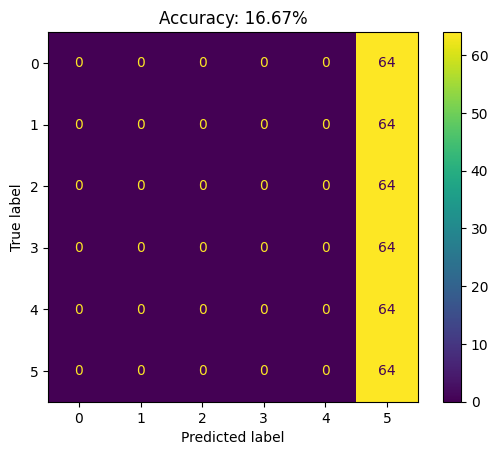

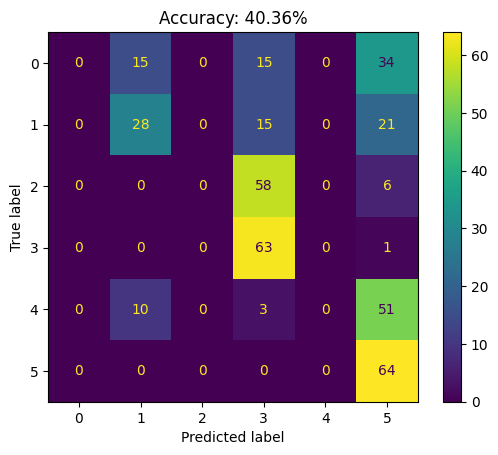

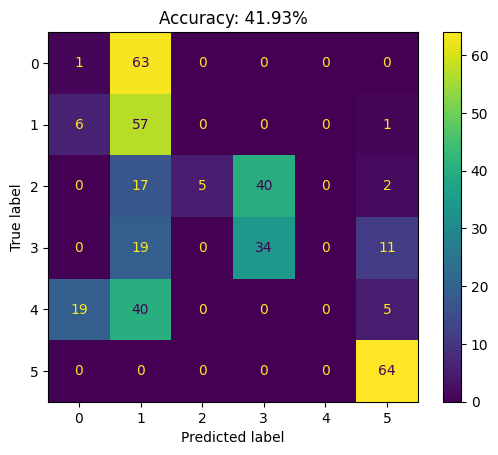

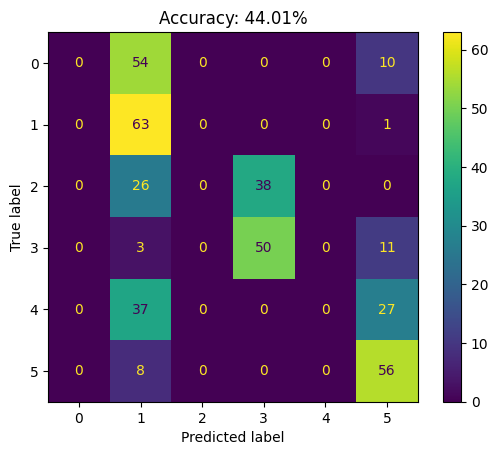

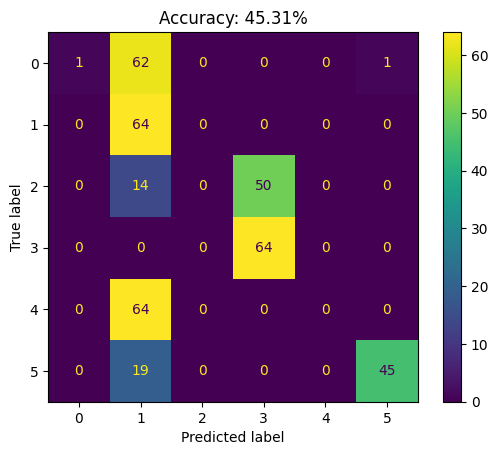

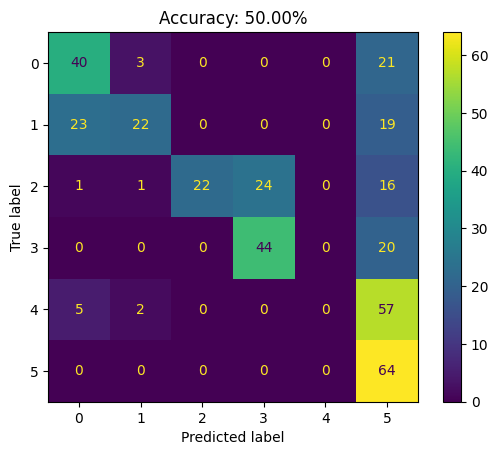

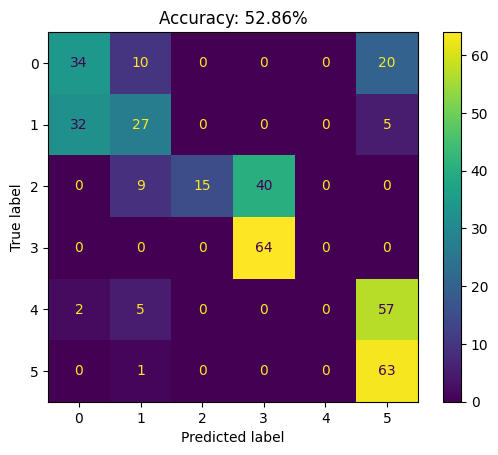

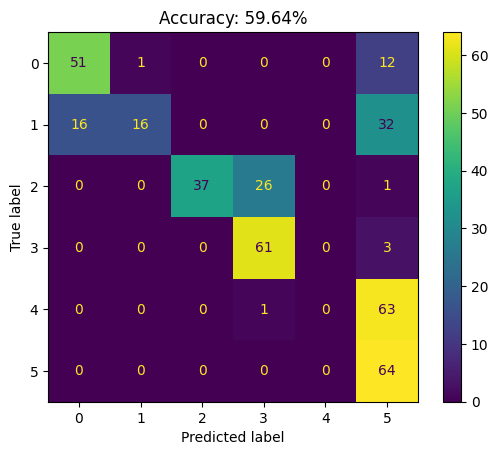

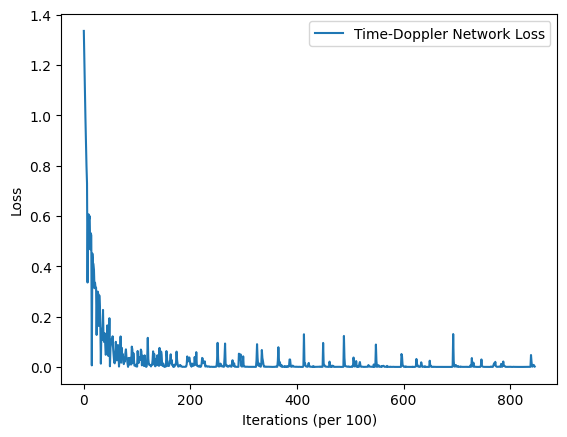

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm
#from model import ResNet, ResidualBlock
#from dataset import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt


if __name__=="__main__":
    device=torch.device('cuda:0')
    #trial_list=glob.glob(data_dir + '/Dataset/outdoor/Time_Doppler_img/3.29_time_dop/*')
    trial_list=glob.glob(data_dir + '/Dataset/outdoor/Time_Doppler_1500fm/3.29_time_dop_1500/*')
    # trial_path_list=glob.glob('/local/scratch/c/cao393/mobicom2208/driver_activity/exp1_from_hanyu/data/raw_xy_dop_micro/adc*/')
    # trial_path_list = glob.glob(
    #     '/local/scratch/c/cao393/mobicom2208/driver_activity/exp2_in_car/data/raw_micro_combine/adc*/')
    # trial_list=[trial.split("/")[-2] for trial in trial_path_list]
    # trial_list = ['Dataset/car/Time_Doppler_img/adc_data_m_hl_Raw_combine', 
    #               'Dataset/car/Time_Doppler_img/adc_data_m_hr_Raw_combine',
    #               'Dataset/car/Time_Doppler_img/adc_data_m_lb_Raw_combine',
    #               'Dataset/car/Time_Doppler_img/adc_data_m_lf_Raw_combine',
    #               'Dataset/car/Time_Doppler_img/adc_data_m_pu_Raw_combine']

    ds_train=dataset_time_dop_train(rnn_length=16, trial_list=trial_list)
    dl_train=DataLoader(ds_train, batch_size=8,shuffle=True,drop_last=True,num_workers=2,prefetch_factor=2)
    ds_eval = dataset_time_dop_eval(trial_list=trial_list)
    net = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
    optimizer=torch.optim.Adam(net.parameters(),lr=0.001)
    epoch_num=100
    iteration=0
    max_acc = 0
    new_acc = 0
    loss_running_record = []
    for epoch in range(epoch_num):
        running_loss = 0.0
        print("---------------epoch: {}----------------".format(epoch+1))
        for _, (images, labels) in enumerate(dl_train):
            images=images.to(device)
            labels=labels.to(device)
            net.train()
            optimizer.zero_grad()
            pred = net(images)
            #print(pred.shape)
            criterion = nn.CrossEntropyLoss()
            #print(labels.shape)
            labels = labels.view(-1)
            #print(labels.shape)
            loss = criterion(pred.view(-1,6), labels.to(torch.long))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if iteration %100==0:
                loss_running_record.append(running_loss/100)    # record the loss
                print("iteration:{}, loss:{:5f}".format(iteration,loss.item()))
                running_loss = 0.0
            if iteration%1000==0:
                net.eval()
                correct = 0
                total = 0
                label_list=[]
                pred_list=[]

                correct_train = 0
                total_train = 0
                label_list_train=[]
                pred_list_train=[]
                with torch.no_grad():
                    for trial_no in range(len(trial_list)):
                        eval_img_array, eval_label_array, train_img_array,train_label_array = ds_eval.get_item(trial_no)
                        eval_img_array=torch.from_numpy(eval_img_array[np.newaxis,...]).to(device)
                        eval_pred=net(eval_img_array)
                        eval_pred=torch.softmax(eval_pred,-1)
                        _, eval_pred=torch.max(eval_pred.data, 2)
                        total += eval_label_array.shape[0]
                        eval_pred=eval_pred.view(-1).cpu().numpy()
                        label_list+=eval_label_array.tolist()
                        pred_list+=eval_pred.tolist()
                        correct += np.sum((eval_pred == eval_label_array))

                        train_img_array=torch.from_numpy(train_img_array[np.newaxis,...]).to(device)
                        train_pred=net(train_img_array)
                        train_pred=torch.softmax(train_pred,-1)
                        _, train_pred=torch.max(train_pred.data, 2)
                        total_train += train_label_array.shape[0]
                        train_pred=train_pred.view(-1).cpu().numpy()
                        label_list_train+=train_label_array.tolist()
                        pred_list_train+=train_pred.tolist()
                        correct_train += np.sum((train_pred == train_label_array))


                print("accuary:{:5f}".format(correct/total))
                new_acc = correct/total
                print("accuary_train:{:5f}".format(correct_train / total_train))
                if new_acc > max_acc:
                    max_acc = new_acc
                    state = {
                        'model_gs': net.state_dict(),
                        'optimizer_gs': optimizer.state_dict(),
                    }
                    torch.save(state, data_dir + '/td1_model_out100e/batch_{:05d}.pth'.format(iteration) )
                    # torch.save(state, './')
                    cm=confusion_matrix(label_list, pred_list)
                    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                    disp.plot()
                    disp.ax_.set_title(f'Accuracy: {((correct/total)*100):.2f}%')
                    # plt.show()
                    plt.savefig(data_dir + "/plots/plots4_td_out_100epochs/{:05d}_cm.png".format(iteration))
                    
                #plt.savefig("./")
            # if iteration % 1000 == 0:
            #     state = {
            #         'model_gs': net.state_dict(),
            #         'optimizer_gs': optimizer.state_dict(),
            #     }
            #     torch.save(state, data_dir + '/td_model_out100e/batch_{:05d}.pth'.format(iteration) )
            #     # torch.save(state, './')
            iteration+=1

    plt.figure()     
    plt.plot(loss_running_record[2:], label='Time-Doppler Network Loss')
    plt.legend()
    plt.xlabel('Iterations (per 100)')
    plt.ylabel('Loss')
    plt.savefig(data_dir + "/plots/plots4_td_out_100epochs/total_loss.png")
    plt.show()

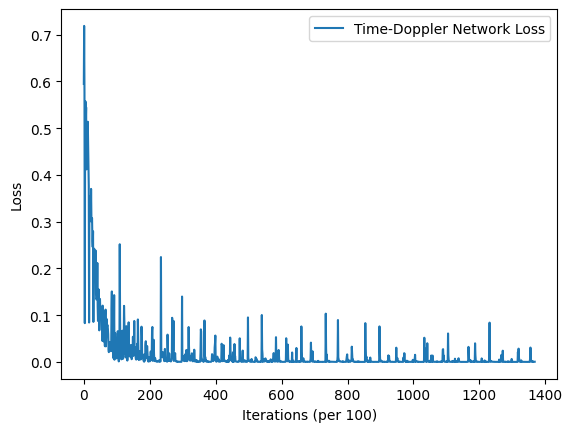

In [ ]:
plt.figure()     
plt.plot(loss_running_record[10:], label='Time-Doppler Network Loss')
plt.legend()
plt.xlabel('Iterations (per 100)')
plt.ylabel('Loss')
plt.savefig(data_dir + "/plots/plots2_td_out_100epochs/total_loss_zoom1.png")
plt.show()

In [15]:
import time

device=torch.device('cuda:0')
trial_list=glob.glob(data_dir + '/Dataset/outdoor/Time_Doppler_1500fm/3.29_time_dop_1500/*')
ds_eval = dataset_time_dop_eval(trial_list=trial_list)
net = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
#net.load_state_dict(torch.load(data_dir + '/td_model_out150e/batch_81000.pth'))
with torch.no_grad():
  for trial_no in range(len(trial_list)):
    start_time = time.perf_counter()
    eval_img_array, eval_label_array, train_img_array,train_label_array = ds_eval.get_item(trial_no)
    #print(eval_img_array.shape)
    eval_img_array=torch.from_numpy(eval_img_array[np.newaxis,...]).to(device)
    eval_pred=net(eval_img_array)
    eval_pred=torch.softmax(eval_pred,-1)

    current_time = time.perf_counter()
    time_elapsed = current_time-start_time
    print(time_elapsed)

0.0032168210000236286
0.003498727000078361
0.0027167450000433746
0.0033299699999815857
0.003304932999981247
0.004736675999993167
0.0032392470000104368
0.0031522379999842087
0.0032146489999149708
0.0032050519999984317
0.003114503999995577
0.003217363999965528
0.004014972000049966
0.0032362289999809946
0.0032102210000175546
0.0031284440000263203
0.0032085980000147174
0.0032280099999297818
0.0030784029999040285
0.00307243899999321
0.0030562069999859887
0.00307148199999574
0.0030873769999288925
0.003328146000058041


In [12]:
!nvidia-smi
!nvidia-smi -q

Tue Apr 25 21:44:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |    203MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------